Voici le projet d'OCVX du groupe de Hadrien Berthier, Axel Petit et Franck Thang

Ce projet est rélalisé en python 3, et utilisera les bibliothèques scipy numpy et panda

Ce document fait objet de rapport, en plus du code il comportera des explications et des annotations.

Question OCVX: 

Conditionnement en prenant en compte les valeurs propres de la hessienne,
Le "epoch" sur le step decay, quelle est sa valeur ? et quelles sont les diff entre toutes les techniques
Adam optimisation non performant 
Récapituler sur les problèmes d'optimisation avec contraintes d'égalites
Explication de la méthode de Newton implémenter



In [1]:
import warnings
import time
import numpy as np
import scipy as sc
import math
import pandas as pd
from matplotlib import pyplot as plt
from numpy import linalg as LA
from scipy import misc

In [2]:
def plot_2d(ob_function, xmin=-2, xmax=2, ymin=-2, ymax=2, nb_pts_h=50, nb_pts_v=50):
    x1 = np.linspace(xmin, xmax, nb_pts_h)
    x2 = np.linspace(ymin, ymax, nb_pts_v)
    X, Y = np.meshgrid(x1, x2)
    Z = ob_function(np.stack((X,Y), axis=0))
    plt.contour(X, Y, Z, cmap='RdGy')

In [3]:
def partial(f, x, i=0, dx=1e-6):
    """Computes i-th partial derivative of f at point x.
    
    Args:
        f: objective function.
        x: point at which partial derivative is computed.
        i: coordinate along which derivative is computed.
        dx: slack for finite difference.
        
    Output:
        (float)

    """
    x = x.reshape(1, -1)
    h = np.zeros(x.shape)
    h[0, i] = dx
    return (f(x + h) - f(x - h)) / (2*dx)

In [4]:
def gradient(f, x, dx=1e-6):
    """Computes gradient of f at point x.
    
    Args:
        f: objective function.
        x: point at which gradient is computed.
        dx: slack for finite difference of partial derivatives.
        
    Output:
        (ndarray) of size domain of f.
        
    """
    x = x.reshape(1, -1)
    dim = x.shape[1]
    return np.array([partial(f, x, i, dx) for i in range(dim)]).reshape(1, -1)

In [5]:
def hessian(f, x):
    N = x.shape[0]
    hessian = np.zeros((N, N))
    gd = gradient(f, x)
    eps = LA.norm(gd) * np.finfo(np.float32).eps 
    for i in range(N):
        xx0 = 1. * x[i]
        x[i] = xx0 + eps
        gd_1 =  gradient(f, x)
        hessian[:,i] = ((gd_1 - gd)/eps).reshape(x.shape[0])
        x[i] =xx0
    return hessian

In [6]:
def plot_graph(f, iters, iters_dir):
    nb_pts, x_mi, x_ma, y_mi, y_ma = 200, -2, 2, -2, 2
    fig, ax = plt.subplots(figsize=(15, 15))
    x, y = np.linspace(x_mi, x_ma, nb_pts), np.linspace(x_mi, x_ma, nb_pts)
    X, Y = np.meshgrid(x, y)
    ## Reshaping X, Y for proper evaluation by input function
    x_y = np.vstack([X.reshape(1, -1), Y.reshape(1, -1)]).reshape(1, 2, -1)
    ax.set_xlim(x_mi, x_ma)
    ax.set_ylim(y_mi, y_ma)
    ax.contour(X, Y, f(x_y).reshape(nb_pts, -1), 15)
    ax.quiver(iters[:, 0], iters[:, 1], iters_dir[:, 0], iters_dir[:, 1],
              color='b', scale=6, width=0.002, headwidth=4, headlength=5)
    ax.plot(iters[:, 0], iters[:, 1], 'b.')

In [7]:
class GD():
    """Gradient Descent Object.
    
    Implements gradient descent aiming to compute optimal objective 
    value of convex functions and local optimal ones of none 
    convex functions.
    
    """    
    def __init__(self, d_dir=gradient, 
                 rate=(lambda x, y, z, grad: 0.01), 
                 decay=(lambda x: np.linalg.norm(x)), 
                 tol=1e-6, max_iter=1000, grad=gradient):
        """        
        Instantiates a GD object.
    
        Attributes:
        d_dir: function computing descent direction.
        rate: function computing learning rate ; takes in
              - f (function): objective function
              - x (ndarray): current iterate
              - dir_x (ndarray): output of a descent direction function
              - grad (ndarray): gradient function.
        decay: function computing decay.
        tol: slack tolerance.
        max_iter: upper bound on number of iterations.
    
        """
        self.d_dir = d_dir
        self.rate = rate
        self.decay = decay
        self.tol = tol
        self.max_iter = max_iter
        self.grad = gradient
    
    def rate_set(self, rate):
        self.rate = rate
    
    def compute_rate(self,  nb_iter, rate_fn=None, decay=None, f=None, x=None, dir_x=None):
        if (rate_fn != None):
            if (rate_fn == "exp_decay"):
                return self.rate(nb_iter)
            if (rate_fn == "time_based_decay"):
                return self.rate(nb_iter, decay)
            if (rate_fn == "step_decay"):
                return self.rate(nb_iter)
        return self.rate(f, x, dir_x, nb_iter) 
    
    def __call__(self, x, f, rate_fn=None):
        """Calling gradient descent object with specific starting point and optimal function.
        
        Args:
            x: initial starting point for descent.
            f: objective function of optimisation problem.
        
        Output:
            (float) sub-optimal value up to tolerance if execution is proper.
            (ndarray) list of gradient descent iterates.
            
        """
        x = x.reshape(1, -1)
        n_iter = 0
        dir_x = -self.d_dir(f, x, self.tol)
        rate_var = 0
        grad_f_x = self.grad(f, x)
        decay = self.decay(grad_f_x)
        
        rate_var = self.compute_rate(n_iter, rate_fn, decay, f, x, dir_x)
        delta_x = rate_var * dir_x
        iters, iters_dir = x, delta_x
        while decay > self.tol and n_iter < self.max_iter:
            ## Deciding on direction
            dir_x = -self.d_dir(f, x, self.tol)
            rate_var = self.compute_rate(n_iter, rate_fn, decay, f, x, dir_x)
            delta_x = rate_var * dir_x
            ## Updating iterate
            x = x + delta_x
            ## Storing on-going data
            iters_dir = np.vstack([iters_dir, delta_x])
            iters = np.vstack([iters, x])
            ## Computing decay
            grad_f_x = self.grad(f, x)
            decay = self.decay(grad_f_x)
            ## Updating iteration number
            n_iter += 1
        msg = " Iteration nu. = {}\n approx. = {}\n ob value = {}\n and decay = {}."
        print(msg.format(n_iter, x.flatten(), f(x), decay))
        if decay > self.tol:
            warnings.warn("Decay didn't get under tolerance rate.", RuntimeWarning)
        return (x, iters, iters_dir, n_iter)

In [8]:
class backtracking():
    def __init__(self, alpha=0.01, beta=0.8, max_iter=100):
        self.alpha = alpha
        self.beta = beta
        self.max_iter = max_iter
    def __call__(self, f, x, dir_x, n_iter=None):
        n_while = 0
        t = 1
        x = x.reshape(1, -1)
        grad_f = gradient(f, x)
        while f(x + t*dir_x) > f(x) + self.alpha*t*grad_f.dot(dir_x.T) and n_while < self.max_iter:
            t = self.beta*t
            n_while += 1
        return t

Question 1.1

1) Construction de famille qui ont des nombres de conditionnement (>=1)

In [9]:
def generate_family_fc(theta=1):
    return lambda x: x[0, 0]**2 + theta*x[0, 1]**2

In [10]:
def generate_family_non_convex(theta=1):
    return lambda x: -np.exp(x[0, 0] + theta * x[0, 1])

2) Tracer le nombre d'itérations d'une descente de gradient à pas constant contre le nombre de conditionnement d'une même famille

In [ ]:
DG_classic = GD()
DG_classic.rate_set(lambda x, y, z, grad: 0.05)
n_iters = []
for i in range(1, 500):
    print("Iteration", i)
    f = generate_family_fc(i)
    op_pt, iters, iters_dir, n_iter = DG_classic(np.array([1, 1]), f)
    n_iters.append(n_iter)

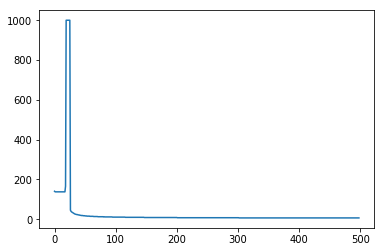

In [12]:
plt.plot(n_iters)

On constate dans ce graphe 3 phases différentes, 
La première étape montre que le nombre d'itérations diminue au fur et à mesure que le nombre de conditionnement s'élève.
Ensuite la deuxième étape dépend de la précision machine, ce qui s'explique par un nombre d'itérations élevée ou celui ci peut atteindre le max_iter.
Troisième étape, la machine fait des erreurs de précisions et donne des résultats incorrects.

3) Etude avec différents pas constant

In [ ]:
DG_classic = GD()
f3 = generate_family_fc(3)
iter_dir_arr = []
iter_arr = []
steps = []
n_iters = []
for i in np.arange(0.01, 0.9, 0.01):
    DG_classic.rate_set(lambda x, y, z, f: i)
    op_pt, iters, iters_dir, n_iter = DG_classic(np.array([1, 1]), f3)
    steps.append(i)
    iter_arr.append(iters)
    iter_dir_arr.append(iters_dir)
    n_iters.append(n_iter)

Nous avons testé notre fonction sur différents pas constant avec un range allant de 0.01 à 0.1.
La fonction f choisi est f(x, y) = x² + 3y², le conditionnement est de 3.
Le nombre d'itérations diminue en fonction du pas choisi, le pas optimal dans notre exemple est 0.1.
A partir d'un pas de 0.4, la descente de gradient possède un nombre d'itérations faible mais la valeur objective est incorrecte. Ceci peut s'expliquer par une erreur de précision machine ou par le fait que la descente à dépasser la zone de convergence.

Question 1.2

In [15]:
def d_sgd(f, x, dx=1e-6):
    x = x.reshape(1, -1)
    dim = x.shape[1]
    sdescent = np.array([0]*dim, dtype=float).reshape(1, -1)
    ## Computing the highest absolute value among coeffs 
    ## of coordinates in gradient.
    abs_grad = np.abs(gradient(f, x, dx))
    imax_diff = np.argmax(abs_grad) 
    sdescent[0, imax_diff] = abs_grad[0, imax_diff]
    return sdescent

In [16]:
# Norme l1
DG_l1 = GD(d_dir=d_sgd)
DG_l1.rate_set(lambda x, y, z, grad: 0.1)
# Norme l2
DG_l2 = GD()
DG_l2.rate_set(lambda x, y, z, grad: 0.1)
f3 = generate_family_fc(3)
x0 = np.array([1.5, 1.5], dtype=float)
op_pt_l1, iters_l1, iters_dir_l1, n_iter_l1 = DG_l1(x0, f3)
op_pt_l2, iters_l2, iters_dir_l2, n_iter_l2 = DG_l2(x0, f3)

 Iteration nu. = 86
 approx. = [3.85665131e-07 1.03079215e-07]
 ob value = 1.8061356674668494e-13
 and decay = 9.886668078992277e-07.
 Iteration nu. = 67
 approx. = [ 4.82081413e-07 -9.18170480e-23]
 ob value = 2.324024890502719e-13
 and decay = 9.641628266019635e-07.


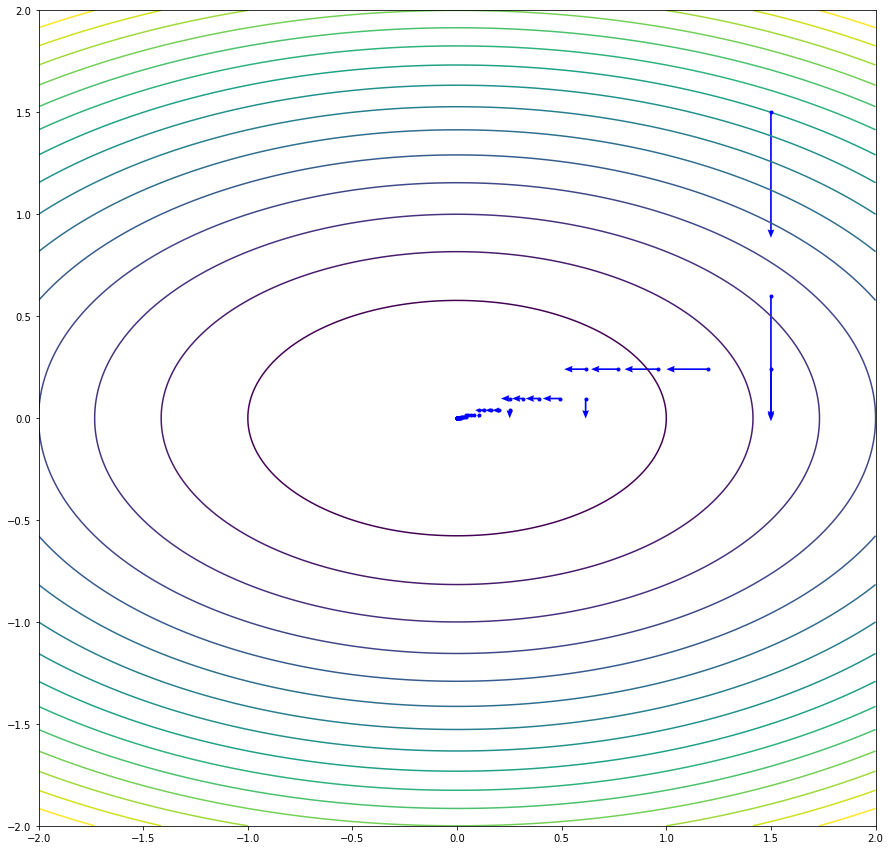

In [17]:
plot_graph(f3, iters_l1, iters_dir_l1)

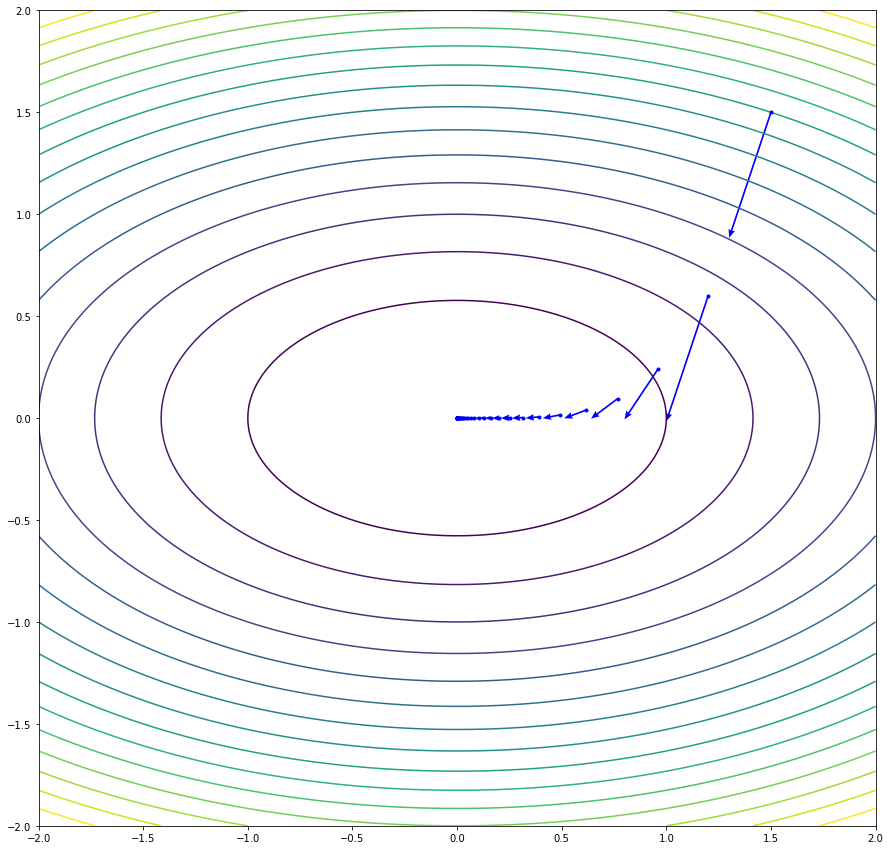

In [18]:
plot_graph(f3, iters_l2, iters_dir_l2)

In [ ]:
# Norme l1
DG_l1 = GD(d_dir=d_sgd)
DG_l1.rate_set(lambda x, y, z, grad: 0.1)
# Norme l2
DG_l2 = GD()
DG_l2.rate_set(lambda x, y, z, grad: 0.1)
f3 = generate_family_fc(3)
x0 = np.array([1, 1], dtype=float)
n_iters_l1 = []
n_iters_l2 = []
steps = []
for i in np.arange(0.01, 0.3, 0.01):
    DG_l1.rate_set(lambda x, y, z, f: i)
    DG_l2.rate_set(lambda x, y, z, f: i)
    op_pt_l1, iters_l1, iters_dir_l1, n_iter_l1 = DG_l1(x0, f3)
    op_pt_l2, iters_l2, iters_dir_l2, n_iter_l2 = DG_l2(x0, f3)
    steps.append(i)
    n_iters_l1.append(n_iter_l1)
    n_iters_l2.append(n_iter_l2)

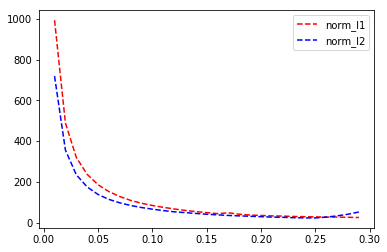

In [20]:
plt.plot(steps, n_iters_l1, 'r--', label = 'norm_l1')
plt.plot(steps, n_iters_l2, "b--", label = 'norm_l2')
plt.legend(loc='upper right')

On remarque que la norme L2 converge un peu plus rapidement que la norme L1, le gradient en L1 prend en compte qu'un seul axe et indique une direction de cet axe la.
Pour la norme L2, elle prend en compte toutes les coordonnées du gradient pour indiquer une direction.

1.2 Accélération de convergence

Question 1-3

Learning rate is a hyper-parameter that controls how much we are adjusting the weights of our network with respect the loss gradient. The lower the value, the slower we travel along the downward slope.

In [21]:
def time_based_decay(nb_iter, decay):
    lrate = (1 / (1 + decay * nb_iter))
    return lrate

In [22]:
DG_l2 = GD()
DG_l2.rate_set(time_based_decay)
f3 = generate_family_fc(3)
x0 = np.array([1.5, 1.5], dtype=float)
op_pt_l2, iters_l2, iters_dir_l2, n_iter_l2 = DG_l2(x0, f3, rate_fn="time_based_decay")

 Iteration nu. = 1000
 approx. = [-0.43263741 -0.17704356]
 ob value = 0.28120839179832724
 and decay = 1.3700728762669112.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: Decay didn't get under tolerance rate.


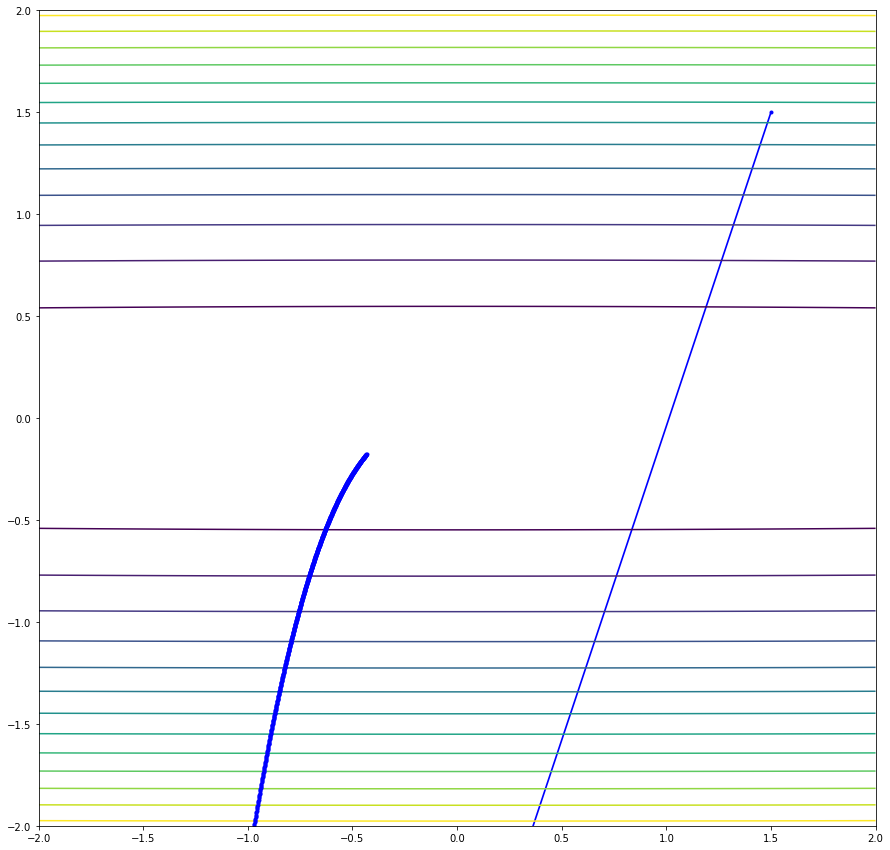

In [23]:
plot_graph(f, iters_l2, iters_dir_l2)

In [24]:
def step_decay(n_iter, initial_lrate=0.1, drop=0.5, epochs_drop=10.0):
    lrate = initial_lrate * math.pow(drop, math.floor((1+n_iter)/epochs_drop))
    return lrate


In [25]:
DG_l2 = GD()
DG_l2.rate_set(step_decay)
f3 = generate_family_fc(3)
x0 = np.array([1, 1], dtype=float)
op_pt_l2, iters_l2, iters_dir_l2, n_iter_l2 = DG_l2(x0, f3, rate_fn="step_decay")

 Iteration nu. = 1000
 approx. = [1.69234116e-02 3.12784287e-07]
 ob value = 0.000286401859829027
 and decay = 0.03384682321381102.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: Decay didn't get under tolerance rate.


In [35]:
def exp_decay(n_iter, initial_lrate=0.5, k=0.1):
   lrate = initial_lrate * np.exp(-k*n_iter)
   return lrate

In [36]:
DG_l2 = GD()
DG_l2.rate_set(exp_decay)
f3 = generate_family_fc(3)
x0 = np.array([1, 1], dtype=float)
op_pt_l2, iters_l2, iters_dir_l2, n_iter_l2 = DG_l2(x0, f3, rate_fn="exp_decay")

 Iteration nu. = 15
 approx. = [-1.34717041e-11 -8.05194458e-08]
 ob value = 1.9450143652945044e-14
 and decay = 4.831166757455657e-07.


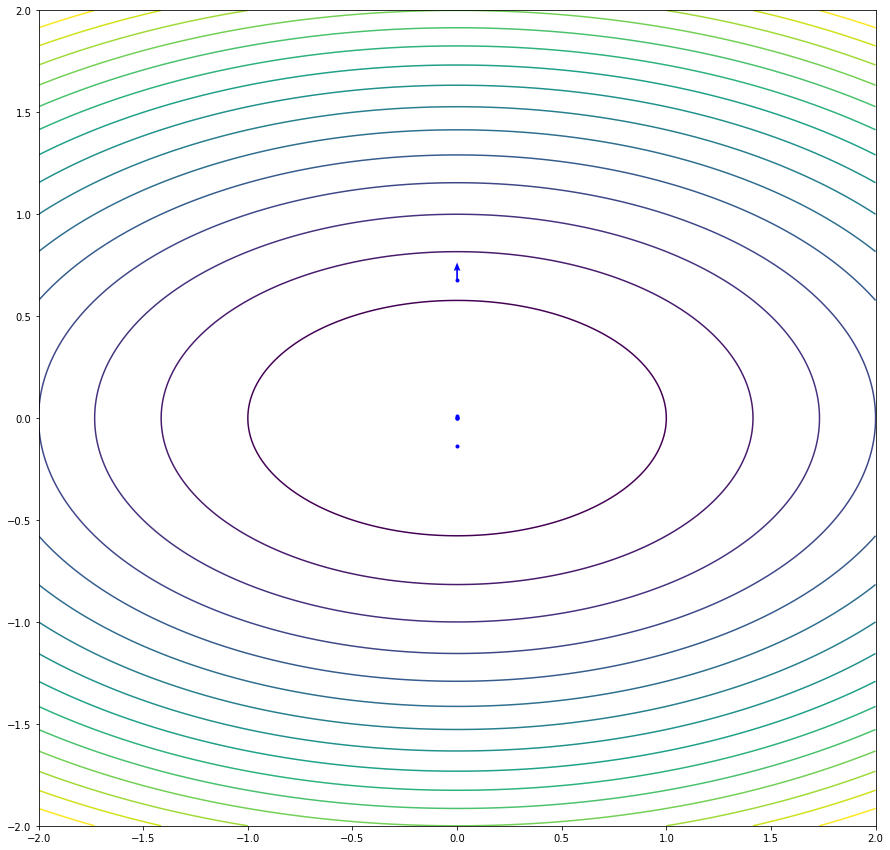

In [37]:
plot_graph(f3, iters_dir_l2, iters_l2)

Question 1-4

1) Nesterov Descent

During the Nesterov momentum you first making a step into velocity direction and then make a correction to a velocity vector based on new location (then repeat).

In [38]:
def nesterov_descent(func, rate, gradient_func, init_x, delta_x=0.0005, epsilon=0.05):
    x = init_x
    x = x.reshape(1, -1)
    lambda_prev = 0
    lambda_curr = 1
    gamma = 1
    y_prev = x

    gradient = gradient_func(func, x)
    num_iter = 0
    iters, iters_dir = x, -rate * gradient
    while np.linalg.norm(gradient) >= epsilon:
        y_curr = x - rate * gradient
        x = (1 - gamma) * y_curr + gamma * y_prev
        iters_dir = np.vstack([iters_dir, -rate * gradient])
        iters = np.vstack([iters, x])
        y_prev = y_curr
        lambda_tmp = lambda_curr
        lambda_curr = (1 + math.sqrt(1 + 4 * lambda_prev * lambda_prev)) / 2
        lambda_prev = lambda_tmp
        gamma = (1 - lambda_prev) / lambda_curr
        gradient = gradient_func(func, x)
        
        num_iter += 1
    msg = " Iteration nu. = {}\n approx. = {}\n ob value = {}\n and decay = {}."
    print(msg.format(num_iter, x.flatten(), y_prev[0], lambda_curr))
    return x, num_iter, iters, iters_dir

In [39]:
f = generate_family_fc(3)
x, num_iter, iters, iters_dir = nesterov_descent(f, 0.01, gradient, np.array([1, 1], dtype=float))

 Iteration nu. = 32
 approx. = [0.02124367 0.00039383]
 ob value = [ 0.03630695 -0.00321503]
 and decay = 9.56097414704707.


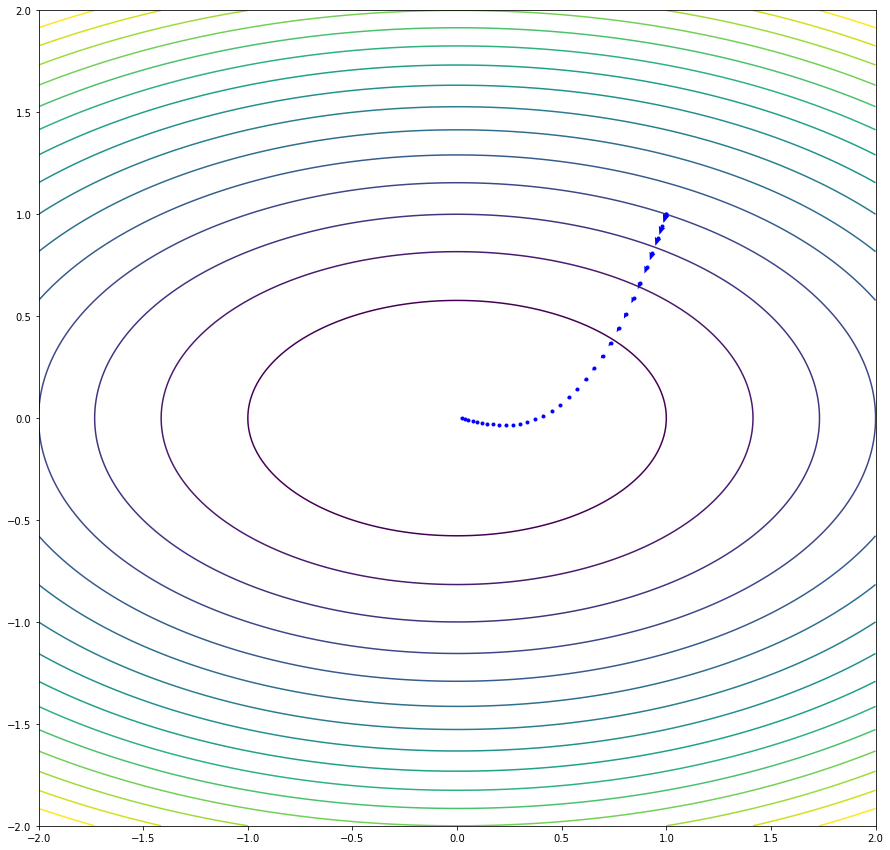

In [40]:
plot_graph(f, iters, iters_dir)

In [41]:
f_non_convex = generate_family_non_convex()
x, num_iter, iters, iters_dir = nesterov_descent(f_non_convex, 0.1, gradient, np.array([1, 1], dtype=float))

 Iteration nu. = 4
 approx. = [2916.65272423 2916.65272423]
 ob value = [2111.88556272 2111.88556272]
 and decay = 2.193527085331054.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


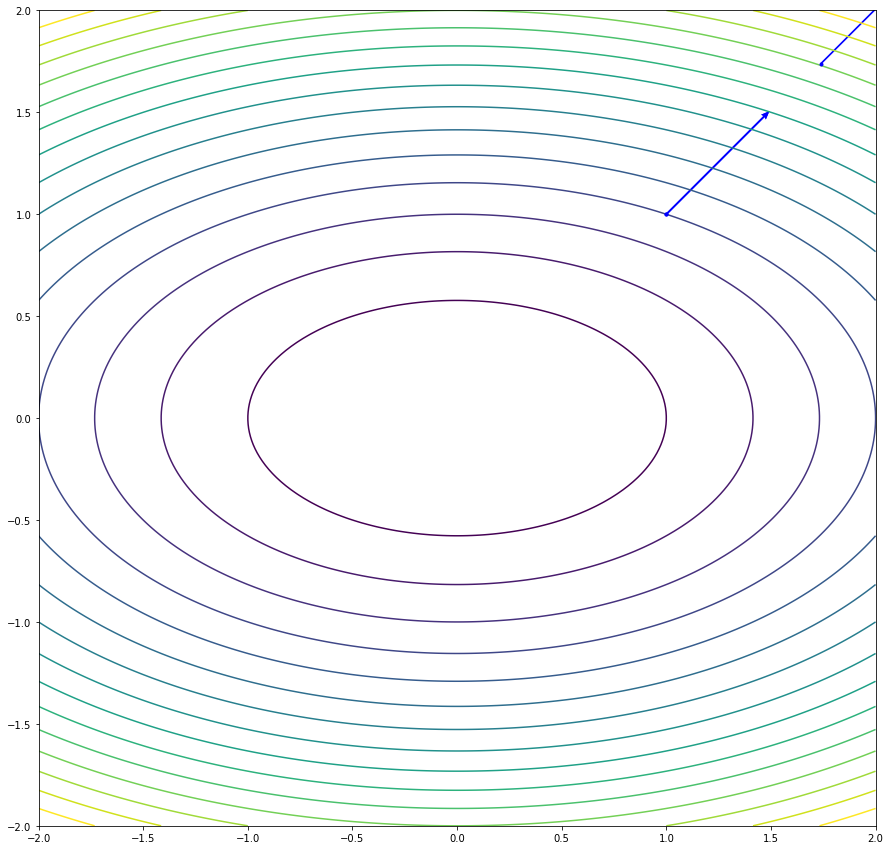

In [42]:
plot_graph(f, iters, iters_dir)

2) Adam Optimization

Adam Optimization is an algorithm that can be used instead of Stochastic Gradient Descent. It's a combination of AdaGrad (Adaptive Gradient Algorithm) and RMSProp (Root Mean Square Propagation). It also updates the learning rate by using the second moments of the gradients

In [43]:
def adam_optimization(func, gradient_func, theta_0, plot_f=(lambda x, y: None), alpha=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-8):
    # Initialization
    m_t = 0 
    v_t = 0 
    t = 0
    g_t = gradient_func(func, theta_0)
    theta_0 = theta_0.reshape(1, -1)
    iters, iters_dir = theta_0, np.array([0, 0])
    while np.linalg.norm(g_t) >= epsilon:
        t+=1
        g_t = gradient_func(func, theta_0)
        m_t = beta_1*m_t + (1-beta_1)*g_t #updates the moving averages of the gradient
        v_t = beta_2*v_t + (1-beta_2)*(g_t*g_t) #updates the moving averages of the squared gradient
        m_cap = m_t/(1-(beta_1**t)) #calculates the bias-corrected estimates
        v_cap = v_t/(1-(beta_2**t)) #calculates the bias-corrected estimates
        delta_x = -(alpha*m_cap)/(np.sqrt(v_cap)+epsilon)
        theta_0 = theta_0 + delta_x #updates the parameters
        iters_dir = np.vstack([iters_dir, delta_x])
        iters = np.vstack([iters, theta_0])
    msg = " Iteration nu. = {}\n approx. = {}\n"
    print(msg.format(t, x.flatten()))
    return theta_0, t, iters, iters_dir

In [44]:
f = generate_family_fc(2)
theta_0, t, iters,iters_dir = adam_optimization(f, gradient, np.array([1, 1]), alpha=0.11, beta_1=0.10, beta_2=0.82, epsilon=1e-8)

 Iteration nu. = 29
 approx. = [2916.65272423 2916.65272423]



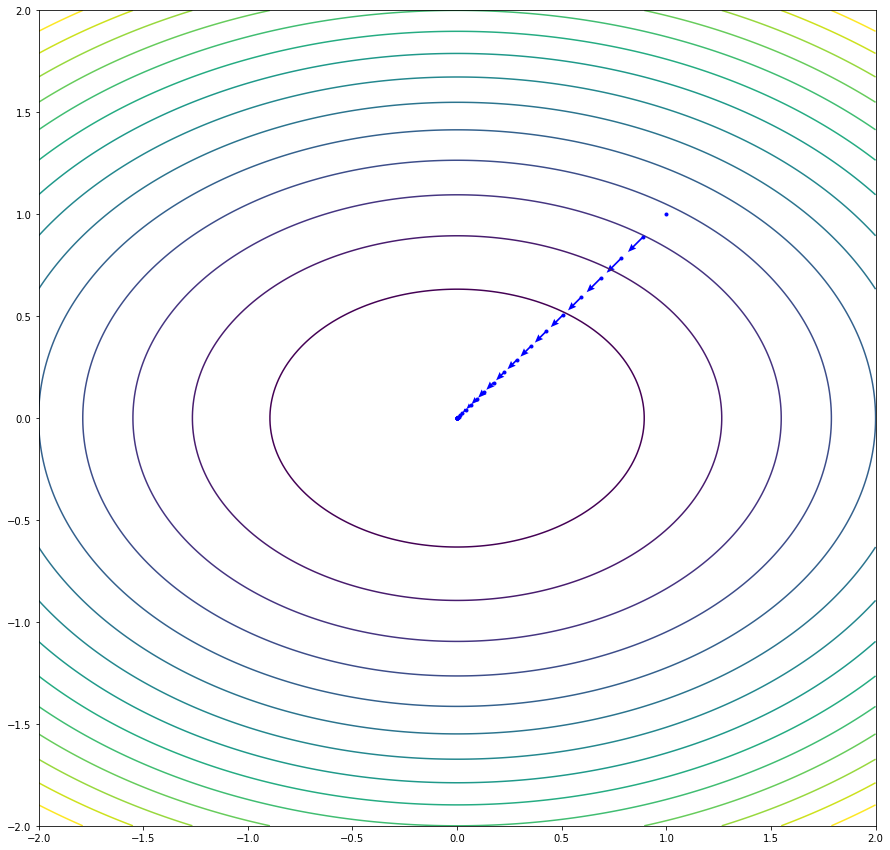

In [45]:
plot_graph(f, iters, iters_dir)

2.1 Méthode de Newton

Question 2.5 Générer des problèmes d'optimisations convexes avec contraintes d'égalité

Question 2.6 Implémenter et tester une méthode de Newton

In [ ]:
def newton_method(f, x, max_iter=10, eps=1e-4, plot_f=(lambda x, y: None)):
    x = x.reshape(1, -1)
    u = x
    v = u - f(u) / misc.derivative(f, x)
    nb_iter = 0
    delta = f(abs(u - v))
    while(delta > eps and nb_iter < max_iter):
        u = v
        v = u - f(u) / gradient(f, u)
        delta = f(abs(u - v))
        nb_iter += 1
    return nb_iter, v

In [ ]:
nb_iter, v = newton_method(lambda x:  x[0,0], np.array([10]), plot_f=(lambda x, y:plt.scatter(x[0, 0], x[0, 0], c='k')))
print(nb_iter)

In [ ]:
def newton_method_bis(f, x, grad, rate=0.2, max_iter=500, eps=1e-4):
    x = x.reshape(2, 1)
    nb_iter = 0
    iters, iters_dir = x.reshape(1, -1), np.array([0, 0])
    while nb_iter < max_iter:
        grad_var = grad(f, x)
        xn = -LA.inv(hessian(f, x)) @ grad_var.T
        crit = -grad_var @ xn
        x = x + rate * xn
        iters_dir = np.vstack([iters_dir, (rate * xn).reshape(1, -1)])
        iters = np.vstack([iters, x.reshape(1, -1)])
        if (crit**2/2) < eps:
            break
        nb_iter += 1
    msg = " Iteration nu. = {}\n approx. = {}\n"
    print(msg.format(nb_iter, x.flatten()))
    return nb_iter, xn, iters, iters_dir

In [ ]:
x = np.array([1.5, 1.5], dtype=float)
f = generate_family_fc(3)
nb_iter, xn, iters, iters_dir = newton_method_bis(f, x, gradient)

In [ ]:
plot_graph(f3, iters, iters_dir)

Question 2.7 Utiliser la méthode de Newton avec contraintes d'égalités pour minimiser des fonctions polynômiales dans les valuations d'un flot sur un graphe

Question 2.8 Quid d'une méthode de Newton

La méthode Quasi Newton permet de résoudre des problèmes non linéiare. Son but est de modifier la matrice hessienne par une matrice plus facile à calculer.